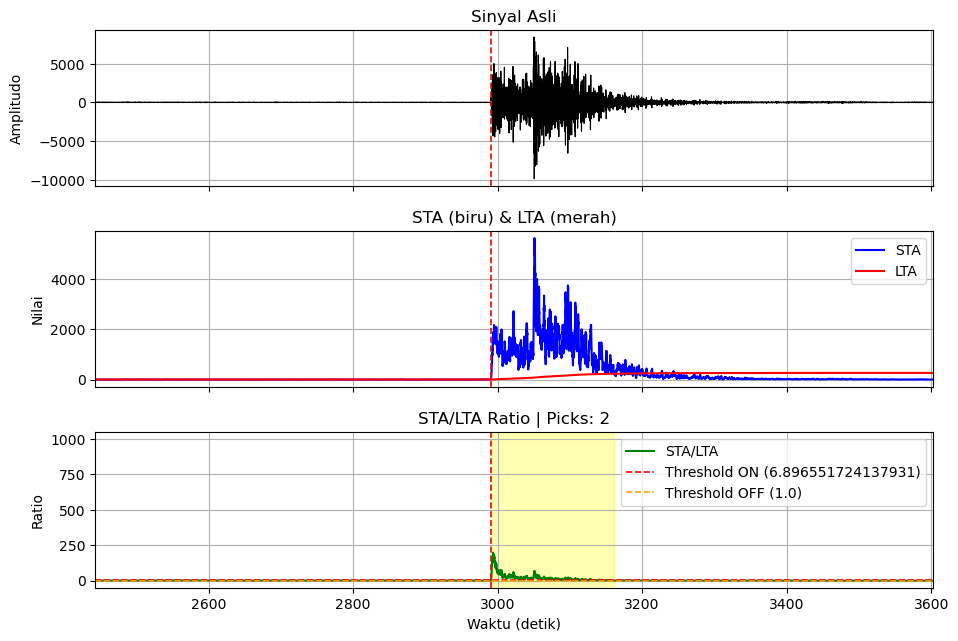

In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from obspy import read
from obspy.core.utcdatetime import UTCDateTime
import os

#  KELAS DETEKTOR STA/LTA
class STALTADetector:
    """
    Kelas ini berfungsi untuk melakukan proses inti STA/LTA:
    - Memuat file MiniSEED
    - Menghitung STA, LTA, dan rasio STA/LTA
    - Menentukan waktu datang (arrival) gelombang
    - Menyimpan hasil deteksi
    """
    def __init__(self):
        self.trace = None
        self.times = None
        self.sta = None
        self.lta = None
        self.ratio = None
        self.triggers = []
        self.picks = []
        self.last_thresh_on = 3.0
        self.last_thresh_off = 1.0

    def load_mseed(self, filepath):
        """Memuat file MiniSEED dan melakukan pra-pemrosesan."""
        try:
            st = read(filepath)
            if len(st) == 0:
                raise ValueError("File MiniSEED kosong")

            self.trace = st[0]
            self.trace.detrend("linear")
            self.trace.filter("bandpass", freqmin=1.0, freqmax=10.0)
            self.times = self.trace.times()  # Menggunakan waktu dalam detik relatif dari starttime
            return True
        except Exception as e:
            messagebox.showerror("Error", f"Gagal load file: {str(e)}")
            return False

    def compute_sta_lta(self, sta_sec=1.0, lta_sec=30.0, thresh_on=3.0, thresh_off=1.0):
        """Menghitung nilai STA, LTA, dan rasio STA/LTA untuk mendeteksi gelombang."""
        if self.trace is None:
            return False
        
        data = np.abs(self.trace.data)
        fs = self.trace.stats.sampling_rate
        nsta = int(sta_sec * fs)
        nlta = int(lta_sec * fs)

        if nsta >= len(data) or nlta >= len(data):
            messagebox.showwarning("Parameter", "Window STA/LTA terlalu besar untuk data")
            return False

        # Hitung cumulative sum agar perhitungan moving average cepat
        cumsum = np.cumsum(data)
        sta = np.zeros(len(data))
        lta = np.zeros(len(data))
        
        sta[nsta:] = cumsum[nsta:] - cumsum[:-nsta]
        sta[:nsta] = cumsum[:nsta]
        sta /= nsta

        lta[nlta:] = cumsum[nlta:] - cumsum[:-nlta]
        lta[:nlta] = cumsum[:nlta]
        lta /= nlta
        
        lta[lta == 0] = 1e-10
        
        self.sta = sta
        self.lta = lta
        self.ratio = sta / lta

        # Simpan nilai threshold terakhir
        self.last_thresh_on = thresh_on
        self.last_thresh_off = thresh_off

        # Deteksi waktu trigger
        self.triggers = []
        self.picks = []
        in_trigger = False

        for i in range(len(self.ratio)):
            if not in_trigger and self.ratio[i] > thresh_on:
                on_time = self.times[i]  # Sekarang dalam detik
                self.picks.append(on_time)
                in_trigger = True
            elif in_trigger and self.ratio[i] < thresh_off:
                off_time = self.times[i]
                self.triggers.append((on_time, off_time))
                in_trigger = False
        
        return True

    def plot(self, ax_trace, ax_stalta, ax_ratio, xlim=None):
        """Menampilkan tiga grafik: sinyal asli, STA-LTA, dan rasio STA/LTA."""
        ax_trace.clear()
        ax_stalta.clear()
        ax_ratio.clear()
        
        if self.trace is None:
            return
        
        # Plot sinyal asli
        ax_trace.plot(self.times, self.trace.data, color='black', linewidth=0.8)
        ax_trace.set_ylabel("Amplitudo")
        ax_trace.set_title("Sinyal Asli")
        ax_trace.grid(True)
        
        # Plot STA dan LTA
        ax_stalta.plot(self.times, self.sta, label='STA', color='blue')
        ax_stalta.plot(self.times, self.lta, label='LTA', color='red')
        ax_stalta.set_ylabel("Nilai")
        ax_stalta.set_title("STA (biru) & LTA (merah)")
        ax_stalta.legend()
        ax_stalta.grid(True)
        
        # Plot rasio STA/LTA
        ax_ratio.plot(self.times, self.ratio, label='STA/LTA', color='green')

        # Garis ambang threshold ON dan OFF 
        ax_ratio.axhline(self.last_thresh_on, color='red', linestyle='--', linewidth=1.2,
                         label=f'Threshold ON ({self.last_thresh_on})')
        ax_ratio.axhline(self.last_thresh_off, color='orange', linestyle='--', linewidth=1.2,
                         label=f'Threshold OFF ({self.last_thresh_off})')

        # Area waktu trigger
        for on_time, off_time in self.triggers:
            ax_ratio.axvspan(on_time, off_time, color='yellow', alpha=0.3)
        for pick in self.picks:
            ax_ratio.axvline(pick, color='red', linestyle='--', linewidth=1.2)
            ax_trace.axvline(pick, color='red', linestyle='--', linewidth=1.2)
            ax_stalta.axvline(pick, color='red', linestyle='--', linewidth=1.2)
        
        ax_ratio.set_ylabel("Ratio")
        ax_ratio.set_xlabel("Waktu (detik)")  # Diubah ke detik
        ax_ratio.set_title(f"STA/LTA Ratio | Picks: {len(self.picks)}")
        ax_ratio.legend()
        ax_ratio.grid(True)

        if xlim:
            ax_trace.set_xlim(xlim)
            ax_stalta.set_xlim(xlim)
            ax_ratio.set_xlim(xlim)


#  KELAS GUI APLIKASI
class STALTAApp(tk.Tk):
    """Aplikasi GUI STA/LTA untuk deteksi waktu datang gelombang."""
    def __init__(self):
        super().__init__()
        self.title("STA/LTA Detector - Deteksi Waktu Datang Gelombang")
        self.geometry("1400x900")  # Diperbesar untuk akomodasi toolbar
        self.detector = STALTADetector()
        self.create_widgets()
        
    def create_widgets(self):
        """Membuat seluruh elemen GUI."""
        # Container untuk control frame dengan scrollbar
        control_container = ttk.Frame(self)
        control_container.pack(side=tk.LEFT, fill=tk.Y)
        
        # Canvas untuk scrolling
        self.canvas = tk.Canvas(control_container, width=300)
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        # Scrollbar vertikal
        scrollbar = ttk.Scrollbar(control_container, orient="vertical", command=self.canvas.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.canvas.configure(yscrollcommand=scrollbar.set)
        
        # Frame di dalam canvas
        control_frame = ttk.Frame(self.canvas, padding=10)
        self.canvas.create_window((0, 0), window=control_frame, anchor="nw")
        
        # Bind untuk update scroll region
        control_frame.bind("<Configure>", lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all")))
        
        ttk.Button(control_frame, text="Load File MiniSEED", command=self.load_file).pack(fill=tk.X, pady=5)
        
        # Keterangan STA & LTA
        ttk.Label(control_frame, text="STA: Short-Term Average (rata-rata jangka pendek)\nLTA: Long-Term Average (rata-rata jangka panjang)\nSTA/LTA digunakan untuk deteksi onset gelombang.", wraplength=200).pack(pady=5)
        
        # STA Slider
        ttk.Label(control_frame, text="STA (detik):").pack(pady=2)
        self.var_sta = tk.DoubleVar(value=1.0)
        self.scale_sta = ttk.Scale(control_frame, from_=0.1, to=10.0, orient=tk.HORIZONTAL, variable=self.var_sta, command=self.update_labels)
        self.scale_sta.pack(fill=tk.X)
        self.scale_sta.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_sta_val = ttk.Label(control_frame, text="1.0")
        self.label_sta_val.pack()
        
        # LTA Slider
        ttk.Label(control_frame, text="LTA (detik):").pack(pady=2)
        self.var_lta = tk.DoubleVar(value=30.0)
        self.scale_lta = ttk.Scale(control_frame, from_=1.0, to=1000.0, orient=tk.HORIZONTAL, variable=self.var_lta, command=self.update_labels)
        self.scale_lta.pack(fill=tk.X)
        self.scale_lta.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_lta_val = ttk.Label(control_frame, text="30.0")
        self.label_lta_val.pack()
        
        # Threshold ON Slider
        ttk.Label(control_frame, text="Threshold ON:").pack(pady=2)
        self.var_on = tk.DoubleVar(value=3.0)
        self.scale_on = ttk.Scale(control_frame, from_=1.0, to=10.0, orient=tk.HORIZONTAL, variable=self.var_on, command=self.update_labels)
        self.scale_on.pack(fill=tk.X)
        self.scale_on.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_on_val = ttk.Label(control_frame, text="3.0")
        self.label_on_val.pack()
        
        # Threshold OFF Slider
        ttk.Label(control_frame, text="Threshold OFF:").pack(pady=2)
        self.var_off = tk.DoubleVar(value=1.0)
        self.scale_off = ttk.Scale(control_frame, from_=0.1, to=5.0, orient=tk.HORIZONTAL, variable=self.var_off, command=self.update_labels)
        self.scale_off.pack(fill=tk.X)
        self.scale_off.bind("<ButtonRelease-1>", lambda e: self.compute())
        self.label_off_val = ttk.Label(control_frame, text="1.0")
        self.label_off_val.pack()
        
        # Zoom Durasi
        ttk.Label(control_frame, text="Zoom Durasi (detik):").pack(pady=5)
        ttk.Label(control_frame, text="Start:").pack()
        self.var_start = tk.DoubleVar(value=0.0)
        self.scale_start = ttk.Scale(control_frame, from_=0.0, to=1000.0, orient=tk.HORIZONTAL, variable=self.var_start, command=self.update_zoom)
        self.scale_start.pack(fill=tk.X)
        self.label_start_val = ttk.Label(control_frame, text="0.0")
        self.label_start_val.pack()
        
        ttk.Label(control_frame, text="End:").pack()
        self.var_end = tk.DoubleVar(value=1000.0)
        self.scale_end = ttk.Scale(control_frame, from_=0.0, to=1000.0, orient=tk.HORIZONTAL, variable=self.var_end, command=self.update_zoom)
        self.scale_end.pack(fill=tk.X)
        self.label_end_val = ttk.Label(control_frame, text="1000.0")
        self.label_end_val.pack()
        
        ttk.Button(control_frame, text="Compute STA/LTA", command=self.compute).pack(fill=tk.X, pady=10)
        ttk.Button(control_frame, text="Save Plot (PNG)", command=self.save_plot).pack(fill=tk.X, pady=5)
        ttk.Button(control_frame, text="Save Picks (TXT)", command=self.save_picks).pack(fill=tk.X, pady=5)
        
        self.label_info = ttk.Label(control_frame, text="Belum ada data", wraplength=200)
        self.label_info.pack(pady=10)
        
        # Info Picks
        self.label_picks = ttk.Label(control_frame, text="Picks Info:\nBelum ada picks", wraplength=200)
        self.label_picks.pack(pady=10)
        
        plot_frame = ttk.Frame(self)
        plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
        
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
        self.fig.tight_layout(pad=3.0)
        self.canvas_plot = FigureCanvasTkAgg(self.fig, plot_frame)
        self.canvas_plot.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Tambahkan Navigation Toolbar untuk zoom, pan, dll.
        self.toolbar = NavigationToolbar2Tk(self.canvas_plot, plot_frame)
        self.toolbar.update()
        self.toolbar.pack(side=tk.BOTTOM, fill=tk.X)
    
    def update_labels(self, event=None):
        """Update label nilai slider secara real-time."""
        self.label_sta_val.config(text=f"{self.var_sta.get():.1f}")
        self.label_lta_val.config(text=f"{self.var_lta.get():.1f}")
        self.label_on_val.config(text=f"{self.var_on.get():.1f}")
        self.label_off_val.config(text=f"{self.var_off.get():.1f}")
    
    def update_zoom(self, event=None):
        """Update zoom xlim."""
        self.label_start_val.config(text=f"{self.var_start.get():.1f}")
        self.label_end_val.config(text=f"{self.var_end.get():.1f}")
        if self.detector.trace is not None:
            xlim = (self.var_start.get(), self.var_end.get())
            self.detector.plot(self.ax1, self.ax2, self.ax3, xlim=xlim)
            self.canvas_plot.draw()
    
    def load_file(self):
        """Memuat file MiniSEED dan menampilkan info dasarnya."""
        filepath = filedialog.askopenfilename(
            title="Pilih file MiniSEED",
            filetypes=[("MiniSEED files", "*.mseed *.MSEED"), ("All files", "*.*")]
        )
        if filepath:
            if self.detector.load_mseed(filepath):
                self.label_info.config(text=f"Loaded: {os.path.basename(filepath)}\n"
                                          f"Channel: {self.detector.trace.stats.channel}\n"
                                          f"Start: {self.detector.trace.stats.starttime}\n"
                                          f"Samp. Rate: {self.detector.trace.stats.sampling_rate} Hz")
                # Update zoom slider max berdasarkan durasi data
                duration = self.detector.times[-1]
                self.scale_start.config(to=duration)
                self.scale_end.config(to=duration)
                self.var_end.set(duration)
                self.label_end_val.config(text=f"{duration:.1f}")
                self.compute()
    
    def compute(self):
        """Mengambil input dari GUI dan menghitung STA/LTA."""
        if self.detector.trace is None:
            messagebox.showwarning("Data", "Load file dulu!")
            return
        
        sta = self.var_sta.get()
        lta = self.var_lta.get()
        thr_on = self.var_on.get()
        thr_off = self.var_off.get()
        
        if self.detector.compute_sta_lta(sta, lta, thr_on, thr_off):
            xlim = (self.var_start.get(), self.var_end.get())
            self.detector.plot(self.ax1, self.ax2, self.ax3, xlim=xlim)
            self.canvas_plot.draw()
            self.label_info.config(text=f"{self.label_info.cget('text').split('Picks')[0]}\n"
                                      f"Picks terdeteksi: {len(self.detector.picks)}")
            # Update info picks
            if self.detector.picks:
                picks_text = "Picks Info:\n"
                for i, pick in enumerate(self.detector.picks, 1):
                    utc_time = self.detector.trace.stats.starttime + pick
                    picks_text += f"Pick {i}: {pick:.3f} detik ({utc_time})\n"
                self.label_picks.config(text=picks_text)
            else:
                self.label_picks.config(text="Picks Info:\nBelum ada picks")
    
    def save_plot(self):
        """Menyimpan hasil plot sebagai file PNG."""
        if self.detector.trace is None:
            return
        filepath = filedialog.asksaveasfilename(defaultextension=".png",
                                                filetypes=[("PNG", "*.png")])
        if filepath:
            self.fig.savefig(filepath, dpi=200)
            messagebox.showinfo("Saved", f"Plot disimpan: {filepath}")
    
    def save_picks(self):
        """Menyimpan waktu pick (arrival) ke file TXT."""
        if not self.detector.picks:
            messagebox.showwarning("Picks", "Belum ada pick!")
            return
        filepath = filedialog.asksaveasfilename(defaultextension=".txt",
                                                filetypes=[("Text", "*.txt")])
        if filepath:
            with open(filepath, "w") as f:
                f.write("STA/LTA Picks (Waktu Datang Gelombang)\n")
                f.write(f"Mulai Data: {self.detector.trace.stats.starttime}\n")
                f.write(f"STA: {self.var_sta.get():.1f}s | LTA: {self.var_lta.get():.1f}s\n")
                f.write(f"Threshold ON/OFF: {self.var_on.get():.1f}/{self.var_off.get():.1f}\n\n")
                f.write("No.\tWaktu (detik)\tWaktu (UTC)\tTimestamp\n")
                for i, pick in enumerate(self.detector.picks, 1):
                    utc_time = self.detector.trace.stats.starttime + pick
                    f.write(f"{i}\t{pick:.3f}\t{utc_time}\t{utc_time.timestamp}\n")
            messagebox.showinfo("Saved", f"Picks disimpan: {filepath}")


#  EKSEKUSI PROGRAM
if __name__ == "__main__":
    app = STALTAApp()
    app.mainloop()
